# SHAPE-BASED SEMI-AUTOMATED SEGMENTATION OF NEURONAL INNERVATION

Author: Christopher Z. Eddy

This pipeline is designed to import immunofluorescence images of axonal components of nerves within 2D samples, process the image with rolling-ball background subtraction of radius R = 5 pixels, a 99.99th percentile renormalization, and top-hat operation with a rectangular structuring element, followed by Moments threshold to segment "innervation objects". The objects are then measured using regionprops, as well as features of the background. We apply several simple thresholds for objects, such as a circularity less than 0.5 (large perimeter, small area) and aspect ratio greater than 2 (elongated). Finally, we use dimensionality reduction (PCA, UMAP) and clustering (K-Means) to identify 'types' of segmented objects, under the assumption that some objects are not true neuron axons and can be filtered out by identifying their subcluster. We save each cluster's segmentations for subsequent downstream analysis. 

We can further enrich this analysis by adding additional shape features that further delineate axon signatures from autofluorescence. Please update the code as you see fit. Included later in this script is an "artificial image" of manually created shapes where you can investigate your proposed thresholding.

*********************************************************************************************************************************

### Perform library imports, define helper functions

In [1]:
import os 
import numpy as np
import glob
from skimage import io, restoration, exposure
from skimage.measure import regionprops_table, label
from scipy.ndimage import binary_fill_holes
import cv2
import pandas as pd
#the following import may be problematic.
from PIL import Image
Image.MAX_IMAGE_PIXELS = None #images may be really large, this is how to overcome error.
from skimage.segmentation import expand_labels
from skimage.morphology import skeletonize, white_tophat, black_tophat, opening, closing, rectangle
from scipy.ndimage.interpolation import rotate
import copy
import psutil

We will also define a progress bar that helps to track how much longer we have to run.

In [2]:
def progbar(curr, total, full_progbar):
	frac = curr/total
	filled_progbar = round(frac*full_progbar)
	print('\r', '#'*filled_progbar + '-'*(full_progbar-filled_progbar), '[{:>7.2%}]'.format(frac), end='')
	sys.stdout.flush()

We'll create a function to import all the necessary filenames, capable of a recursive search.

In [3]:
def import_filenames(filepath, pattern, recursive = False):
        """
        PURPOSE: Imports ALL files from a chosen folder
        INPUTS
        -------------------------------------------------------------
        pattern = list of strings with particular patterns, including filetype! 
                ex: ['_patched','.csv'] will pull any csv files under filepath with the string '_patched' in its file name.

        filepath = string, path for where to search for image files 
                ex: "/users/<username>/folder"

        recursive = boolean, True if you wish for the search for files to be recursive under filepath.
        """
        #generate pattern finding 
        fpattern = ['**{}'.format(x) for i,x in enumerate(pattern)]
        fpattern = ''.join(fpattern)
        #first, get all the filenames in the chosen directory.
        #root directory needs a trailing slash
        # if filepath[-1]!="/":
        #         filepath = filepath+"/"
        fnames = [filename for filename in glob.iglob(filepath + '**/' + fpattern, recursive=recursive)] #best for recursive search one liner.
        #fnames = [x for x in os.listdir(self.filepath) if ".csv" in x]
        fnames = [x for x in fnames if x[0]!="."] #delete hidden files
        fnames.sort() #sort based on name
        return fnames

Define a function to interpret how much memory we are using at the current step.

In [4]:
def calculate_mem_usage():
    # you can have the percentage of used RAM
    print("% Memory used: {}".format(psutil.virtual_memory().percent))

### DATA IMPORTS
Specify the path in which to look for your image files, and provide the pattern in which they are given. If you look for filenames with a particular extension (i.e. '.png'), or a certain pattern in the filename itself (ex. '_subtracted_'), you can also give that in the list of pattern.

In [5]:
#specify the filepath for where to recursively search for .CSV files
search_path = "/home/exacloud/gscratch/CEDAR/cIFimaging/Cyclic_Workflow/2021_DTRON_Neuron"
pattern = ['Scene XXX - TUBB3 SBcells.png']

############################################################################################
paths = ["19142-3/19142-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"30411-3/30411-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"30403-3/30403-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"57494-3/57494-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"31480-3/31480-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"31022-scene0-3/31022-scene0-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"24952-3/24952-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"92352-3/92352-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"38592-3/38592-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"57657-3/57657-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"57658-3/57658-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"54774-3/54774-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"48411-3/48411-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"17633-scene0-3/17633-scene0-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"54776-3/54776-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"31476-3/31476-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png",
"33548-scene00-3/33548-scene00-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png"]

paths = [os.path.join(search_path,x) for x in paths]

save_path = "/home/exacloud/gscratch/CEDAR/cIFimaging/Cyclic_Workflow/2021_DTRON_Neuron/shape_based_segmentation"
paths.sort()
print("Filepaths = ")
for x in paths:
    print(x)
print("Save path = {}".format(save_path))

Filepaths = 
/home/exacloud/gscratch/CEDAR/cIFimaging/Cyclic_Workflow/2021_DTRON_Neuron/17633-scene0-3/17633-scene0-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png
/home/exacloud/gscratch/CEDAR/cIFimaging/Cyclic_Workflow/2021_DTRON_Neuron/19142-3/19142-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png
/home/exacloud/gscratch/CEDAR/cIFimaging/Cyclic_Workflow/2021_DTRON_Neuron/24952-3/24952-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png
/home/exacloud/gscratch/CEDAR/cIFimaging/Cyclic_Workflow/2021_DTRON_Neuron/30403-3/30403-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png
/home/exacloud/gscratch/CEDAR/cIFimaging/Cyclic_Workflow/2021_DTRON_Neuron/30411-3/30411-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png
/home/exacloud/gscratch/CEDAR/cIFimaging/Cyclic_Workflow/2021_DTRON_Neuron/31022-scene0-3/31022-scene0-3_tiffs - Segmentation/Scene XXX - TUBB3 SBcells.png
/home/exacloud/gscratch/CEDAR/cIFimaging/Cyclic_Workflow/2021_DTRON_Neuron/31476-3/31476-3_tiffs - Segmenta

Import the filenames, and define the rolling ball radius background subtraction size for the macro. This step is very important. There is a lot of autofluorescence that needs to be subtracted, but critically the neuronal innervation are made up of thin extensions that are ~5 pixels in width. Using a larger background radius will not allow the algorithm to subtract out the larger cell autofluorescence. 
You can define more than 1 size of background subtraction if you wish. If more than 1 radius is provided, the original image is background subtracted, then thresholded once for each size of background subtraction. The resultant binary images are then "added" together to give a single, final result. 

UPDATE: Note that some preprocess pipelines do not use the user-defined rolling ball radii defined here, but rather in the function definition. Please look carefully below.

### Define a threshold function, using Moments.

In [6]:
def Moments_Thresh(image):
    #H, S, B = cv2.split(img) # spliting the image into HSB
    grey_value = np.arange(256)
    B_freq = cv2.calcHist([image], [0],None,[256],[0,255])
    B_freq = B_freq.reshape((256,))
    B_freq = np.int64(B_freq)
    B_histo = (B_freq, grey_value)

    pix_sum = img.shape[0]*img.shape[1] # calculating the sum of the pixels

    #from the paper, calculating the 3 first odrers

    pj = B_histo[0] / pix_sum 
    pj_z1 = np.power(B_histo[1], 1) * pj
    pj_z2 = np.power(B_histo[1], 2) * pj
    pj_z3 = np.power(B_histo[1], 3) * pj

    m0 = np.sum(pj)
    m1 = np.sum(pj_z1)
    m2 = np.sum(pj_z2)
    m3 = np.sum(pj_z3)

    cd = (m0*m2) - (m1*m1)
    c0 = ((-m2*m2) - (-m3*m1))/cd
    c1 = ((m0*-m3) - (m1*-m2))/cd


    z0 = 0.5 *(-c1 - (np.power(np.power(c1, 2) - 4*c0, 1/2)))
    z1 = 0.5 *(-c1 + (np.power(np.power(c1, 2) - 4*c0, 1/2)))

    pd = z1 - z0
    p0 = (z1 - m1) / pd # p0 should be the percentage of the pixels to which the threshold t should be done

    # using cumulative histogram and comparing it to a target value by calculating the difference. When the difference is the lowest, the index indicates the value of the threshold t
    cum_pix = np.cumsum(B_freq) 
    target_value = p0 * pix_sum

    diff = [(i - target_value) for i in cum_pix]

    t = diff.index(find_nearest(diff, 0))
    return t

def apply_thresh(image, thresh):
    return binary_fill_holes(image>=thresh)

def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    

### Define image pre-processing pipeline
Does not include the top-hat operation

In [7]:
def preprocess_image(image, radius=8):
    #need to convert to a uint8. 
    image = image/65535
    image *= 255 
    image = image.astype(np.uint8)
    # min,max = image.min(), image.max()
    # rescaled = (image - min)/(max-min)
    # percentiles = np.percentile(rescaled, (0.5, 99.5))
    #scaled = exposure.rescale_intensity(rescaled, in_range=tuple(percentiles))
    percentiles = np.percentile(image, (0.5, 99.5))
    image = exposure.rescale_intensity(image, in_range=tuple(percentiles))
    background = restoration.rolling_ball(image, radius=8)
    image=image-background
    return result

In [8]:
def preprocess_image_v2(image, radius=8):
    #need to convert to a uint8.
    min,max = image.min(), image.max()
    print('rescaling')
    image = (image - min)/(max-min)
    print('taking percentiles')
    percentiles = np.percentile(image, (0.5, 99.5))
    image = exposure.rescale_intensity(image, in_range=tuple(percentiles))
    # percentiles = np.percentile(image, (0.5, 99.5))
    # scaled = exposure.rescale_intensity(image, in_range=tuple(percentiles))
    image *= 255
    image = image.astype(np.uint8)
    print('subtracting background')
    background = restoration.rolling_ball(image, radius=radius)
    image=image-background
    print('rescaling preprocessed output')
    min,max = image.min(), image.max()
    image = (image - min)/(max-min)
    image *= 255
    image = image.astype(np.uint8)
    return image

In [9]:
def preprocess_image_v3(image, radius=8):
    #rolling_ball cannot handle a uint8. If you use a floating point 0-1 this may also present an issue with the radius. 
    print('subtracting background')
    background = restoration.rolling_ball(image, radius=radius)
    image=image-background

    print('rescaling preprocessed output')
    min,max = image.min(), image.max()
    image = (image - min)/(max-min)
    image *= 255
    image = image.astype(np.uint8)
    print('taking percentiles')
    percentiles = np.percentile(image, (0.5, 99.5))
    image = exposure.rescale_intensity(image, in_range=tuple(percentiles))
    # percentiles = np.percentile(image, (0.5, 99.5))
    # scaled = exposure.rescale_intensity(image, in_range=tuple(percentiles))
    return image

In [10]:
def preprocess_image_v4(image, im_max = 65535):

    print('rescaling preprocessed output')
    image = image / im_max #rescale. 
    image *= 255
    image = image.astype(np.uint8)

    """
    The following two transformations really do result in the best result for use with Top-hat!
    """
    #rolling_ball cannot handle a uint8. If you use a floating point 0-1 this may also present an issue with the radius. 
    print('subtracting background')
    rad = 25
    background = restoration.rolling_ball(image, radius=rad)#, radius=radius) #the default radius is 100. 
    image=image-background

    #scale. Ultimately, we wwill use the 99.99th percentile of data. 
    percentiles = np.percentile(image, (0.01, 99.99))
    image = exposure.rescale_intensity(image, in_range=tuple(percentiles))

    return image

## Perform operations on images

In [ ]:
write_directories = True
test = [paths[0]]
for pth_i,path in enumerate(test):#paths):
    if pth_i==0:
        #progbar(pth_i, len(paths),20)
        #make a folder in the subpath.
        if write_directories:
            save_pth = os.path.join(save_path, os.path.basename(os.path.dirname(os.path.dirname(x))))
            if not os.path.isdir(save_pth): #make directory
                os.mkdir(save_pth)
        else:
            save_pth = save_path
        print("Reading image")
        calculate_mem_usage()
        img = io.imread(path) #loads as a uint16
        calculate_mem_usage()
        print('preprocessing image')
        img = preprocess_image_v4(img) #auto adjust brightness by scaling percentiles, and use rolling ball subtraction.
        calculate_mem_usage()
        ########ADDING TOP HAT OPERATION##########
        se = rectangle(5,2) #https://scikit-image.org/docs/stable/auto_examples/numpy_operations/plot_structuring_elements.html
        #https://en.wikipedia.org/wiki/Top-hat_transform

        angles = list(range(0,180,15))
        out = np.zeros_like(img)
        for ai,angle in enumerate(angles):
            progbar(ai, len(angles), 20)
            #rotation matrix. 
            rotated_se = rotate(se, angle=angle)
            #wth_my = img_not - opened
            wth = white_tophat(img, rotated_se)
            out = np.where(wth>out, wth, out)
            # closed = closing(img, se)
            # blh_my = closed - img
            #io.imsave(pths[0]+'_white_hat_man.png', wth_my) #write as a png file
        progbar(len(angles), len(angles), 20)
        ############################################

        pths = os.path.basename(path)[:-4]
        #io.imsave(os.path.join(save_pth,pths)+'_white_hat.png', out) #write as a png file, uncomment if you wish to save
        del img
        img = copy.deepcopy(out)
        del out

        # #Find and apply the moments threshold. 
        # print('calculating threshold')
        t = Moments_Thresh(img)
        print('applying threshold')
        thresh_im = apply_thresh(img,t)

        #io.imsave(os.path.join(save_pth,pths)+'_binary.png', thresh_im) #write as a png file

        #measure objects. Can we also include gray level stuff? Yes. Use skimage.measure
        print('labeling')
        lab_im=label(thresh_im, connectivity=1)
        
        #save the label image 
        io.imsave(os.path.join(save_pth,pths)+'_label.png', out)

        print("Expanding background")
        #expand the labels
        expanded = expand_labels(lab_im, distance=10) #here, we want to get info on their local regions
        #I want to take intensity measurements on the objects expanded regions, I don't care about their shapes. 
        expanded = expanded - lab_im #that should work, since the objects aren't touching.
        #io.imsave(os.path.join(save_pth,pths)+'_exp.png', expanded>0) #write as a png file
        #I would like to verify this worked....
        bg_props = regionprops_table(label_image=expanded, intensity_image=img, properties=('intensity_mean', 'intensity_max', 'label'))
        bg_props = pd.DataFrame(bg_props)
        bg_props.rename(columns={'intensity_mean': 'bg_int_mean', 'intensity_max': 'bg_int_max'}, inplace=True)

        print("Skeletonizing objects")
        #let's incorporate the skeletonization of the image. 
        skel_lab = skeletonize(thresh_im)
        skel_lab = np.where(skel_lab,lab_im,0)
        #io.imsave(os.path.join(save_pth,pths)+'_skel.png', skel_lab>0) #write as a png file, uncomment if you want skeleton image.
        
        #now, let's evaluate    

        print('Measuring object features')
        props = regionprops_table(label_image=lab_im,intensity_image=img, properties=('area', 'solidity', 'perimeter_crofton', 'axis_major_length', 'axis_minor_length', 'intensity_mean', 'intensity_max', 'moments_weighted_hu', 'label'))

        skel_props = regionprops_table(label_image=skel_lab, intensity_image=img, properties=('area','intensity_mean', 'intensity_max', 'label'))
        #rename keys in skel_props dictionary.
        skel_props = pd.DataFrame(skel_props)
        skel_props.rename(columns={'area': 'skel_area', 'intensity_mean': 'skel_int_mean', 'intensity_max': 'skel_int_max'},inplace=True)

        #convert to a pandas data table. 
        df = pd.DataFrame(props)
        # if you have a thin line, the minor axis length is often zero. 
        df['axis_minor_length'].where(df['axis_minor_length'] >= 1, 1, inplace=True) #where here kind of works opposite as you expect it to, conditional wise that is. 
        #combine
        df = df.merge(skel_props, left_on='label', right_on='label')
        df = df.merge(bg_props, left_on='label', right_on='label')

        #see the top 5 entries with df.head(5)
        print('Adding measures')
        #first, apply a basic size threshold 
        df.drop(df[df['area'] < 20].index, inplace=True) #eliminate random pixels.

        #sometimes, if you have a line or a single pixel for example, perimeter is not measured correctly 

        #next, calculate circularity
        df['circularity'] = 4 * np.pi * df['area'] / (df['perimeter_crofton'] * df['perimeter_crofton'])
        #also aspect ratio
        df['AR'] = df['axis_major_length'] / df['axis_minor_length']
        #lets also do 
        df['rel_skel'] = df['skel_area'] / df['area']

        #move label to the end. 
        columns = list(df.columns) 
        columns = [x for x in columns if "label" not in x] + ["label"] #put label last
        df = df[columns]

        print('Applying thresholds')
        #okay, we want to screen cells based on circularity (large perimeter, small area)
        df.drop(df[df['circularity']>0.5].index, inplace=True)

        #okay, we want to screen cells based on aspect ratio
        df.drop(df[df['AR']<2].index, inplace=True)

        #lets drop 
        #df.drop(df[df['rel_skel'] < 0.4].index, inplace=True)

        #finally, we'll screen out cell based on the maximum intensity within their regions. 
        # df.drop(df[df['intensity_max']<df.intensity_max.quantile(0.90)].index,inplace=True)

        #finally, return the image you want. 
        print('creating output')
        out = np.zeros(shape=img.shape,dtype=np.bool_)

        for lab in df['label']:
            out[lab_im==lab]=True

        print('writing output')
        #save the image
        pths = os.path.splitext(path) #get file name and path.
        io.imsave(os.path.join(save_pth,pths)+'_output.png', out) #write as a png file

        #save the dataframe.
        df.to_csv(os.path.join(save_pth,pths)+'_dataframe.csv',index=False)

    # progbar(len(paths), len(paths),20)

Reading image
% Memory used: 14.4
% Memory used: 14.8
preprocessing image
rescaling preprocessed output
subtracting background


In [21]:
df.head()

,area,solidity,perimeter_crofton,axis_major_length,axis_minor_length,intensity_mean,intensity_max,moments_weighted_hu-0,moments_weighted_hu-1,moments_weighted_hu-2,...,moments_weighted_hu-6,skel_area,skel_int_mean,skel_int_max,bg_int_mean,bg_int_max,circularity,AR,rel_skel,label
1064,37,0.698113,31.028016,13.764001,4.156725,22.216216,40.0,0.012666,0.000106,4.787077e-07,...,1.550085e-14,13,23.076923,40.0,1.826211,11.0,0.482952,3.311261,0.351351,1065
1322,64,0.727273,43.650203,17.181256,5.935178,42.437500,111.0,0.005939,0.000025,3.129123e-08,...,-9.170526e-17,16,53.750000,111.0,0.914634,11.0,0.422102,2.894817,0.250000,1323
1357,31,0.738095,30.702693,13.121992,3.335021,14.129032,23.0,0.024725,0.000477,1.160247e-06,...,8.029328e-14,11,15.090909,18.0,1.864615,6.0,0.413255,3.934605,0.354839,1358
1370,37,0.578125,43.650203,13.440230,5.714420,14.378378,18.0,0.024421,0.000299,2.808683e-06,...,-1.558522e-13,16,14.812500,18.0,1.299401,11.0,0.244028,2.351985,0.432432,1371
1439,183,0.448529,102.239319,50.962355,9.794702,83.448087,209.0,0.006880,0.000042,6.499405e-08,...,1.033463e-17,46,107.500000,198.0,1.296110,11.0,0.220001,5.203053,0.251366,1440


## CREATE EXAMPLE CASES
This is useful to understand what the scripts above are doing, and how you can further contribute to the pipeline

,area,solidity,perimeter_crofton,axis_major_length,axis_minor_length,label,circularity,AR,skel_area,rel_skel
0,9,1.000000,17.850468,10.327956,1.000000,1,0.354939,10.327956,9,1.000000
1,2,1.000000,4.577636,2.000000,1.000000,2,1.199382,2.000000,2,1.000000
2,1373,0.966221,133.076765,41.811006,41.811006,3,0.974262,1.000000,1,0.000728
3,139,0.668269,63.626828,30.557411,8.211883,4,0.431464,3.721121,22,0.158273
4,26,0.254902,49.473313,28.295148,6.230294,5,0.133488,4.541543,24,0.923077


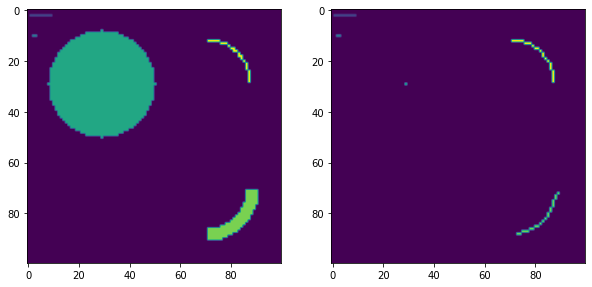

In [22]:
#SOME EXAMPLE TEST CASES
#Circle, similar to the autofluorescence of a lumen.
g = np.zeros(shape=(100,100), dtype=int)
yc = xc = 29
R=21
for ix in range(100):
    for iy in range(100):
        thisRsq = (ix-xc)**2 + (iy-yc)**2
        if thisRsq <= R**2:
            g[ix,iy] = 3

#large lumen like edge
yc = xc = 70
R=21
for ix in range(100):
    for iy in range(100):
        thisRsq = (ix-xc)**2 + (iy-yc)**2
        if thisRsq <= R**2:
            if (thisRsq>(R-5)**2) and (ix>xc) & (iy>yc):
                g[ix,iy]=4

#small, neuron-like twisting thing. 
xc = 29
yc = 70
R=18
for ix in range(100):
    for iy in range(100):
        thisRsq = (ix-xc)**2 + (iy-yc)**2
        if thisRsq <= R**2:
            if (thisRsq>(R-1)**2) and (ix<xc) & (iy>yc):
                g[ix,iy]=5

g[2:3,1:10]=1 #long rectangle

g[10,2:4]=2 #small rectangle 
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(g)
pp = regionprops_table(label_image=g,properties=('area', 'solidity', 'perimeter_crofton', 'axis_major_length', 'axis_minor_length', 'label'))
pp = pd.DataFrame(pp)
pp['axis_minor_length'].where(pp['axis_minor_length'] >= 1, 1, inplace=True) # if you have a thin line, the minor axis length is often zero. 
#pp['axis_major_length'].where(pp['axis_major_length'] >= 1, 1, inplace=True) # if you have a single pixel, the major axis length is often zero. 
pp['circularity'] = 4*np.pi*pp['area'] / (pp['perimeter_crofton']*pp['perimeter_crofton'])
pp['AR'] = pp['axis_major_length'] / pp['axis_minor_length']

#what happens if we skeletonize g?
skel_pp = skeletonize(g>0)
skel_pp = np.where(skel_pp,g,0)
ax2.imshow(skel_pp)
skprops = regionprops_table(label_image=skel_pp, properties=('area', 'label'))
skprops = pd.DataFrame(skprops)
skprops.rename(columns={'area': 'skel_area'},inplace=True)
pp = pp.merge(skprops, left_on='label', right_on='label')
pp['rel_skel'] = pp['skel_area'] / pp['area']#pp['skel_area'] * 2 / pp['perimeter_crofton']

pp

rescaling preprocessed output
subtracting background
 #################### [100.00%]

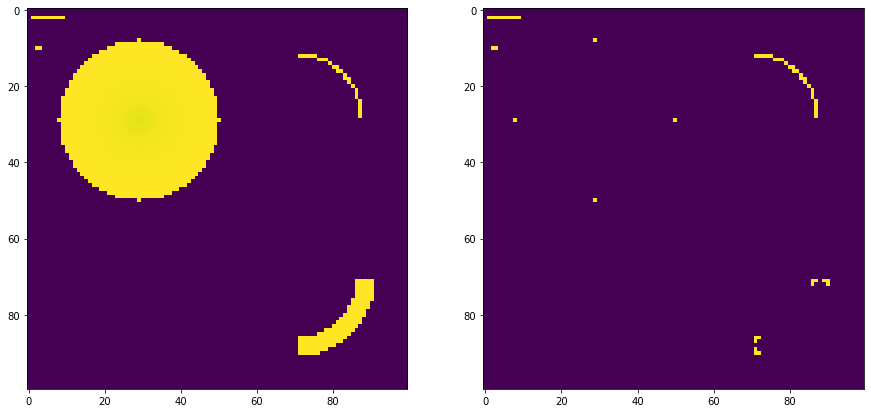

In [21]:
#WHITE HAT OPERATION!!!
img = copy.deepcopy(g)#io.imread(path) #loads as a uint16
img = img > 0 # right now, img is label.
img = img.astype(np.float32)
#print('preprocessing image')
img = preprocess_image_v4(img,im_max=1.0) #auto adjust brightness by scaling percentiles, and use rolling ball subtraction.
#img_not = np.invert(img)
se = rectangle(5,2) #https://scikit-image.org/docs/stable/auto_examples/numpy_operations/plot_structuring_elements.html
#opened = opening(img_not, se) #https://stackoverflow.com/questions/70200419/why-skimage-white-tophat-is-different-from-manually-achieved-top-hat
#https://en.wikipedia.org/wiki/Top-hat_transform
angles = list(range(0,180,15))
out = np.zeros_like(img)
for ai,angle in enumerate(angles):
    progbar(ai, len(angles), 20)
    #rotation matrix. 
    rotated_se = rotate(se, angle=angle)
    #wth_my = img_not - opened
    wth = white_tophat(img, rotated_se)
    out = np.where(wth>out, wth, out)
    # closed = closing(img, se)
    # blh_my = closed - img
    #io.imsave(pths[0]+'_white_hat_man.png', wth_my) #write as a png file
progbar(len(angles), len(angles), 20)
#pths = os.path.splitext(path) #get file name and path.
#io.imsave(pths[0]+'_white_hat.png', out) #write as a png file
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(img)
ax2.imshow(out)
plt.show()


## EMBEDDING TO REMOVE ANY NON-OBJECT OBJECTS

#### Do PCA operation first, if you wish to perform dimensionality reduction prior to embedding

In [30]:
from sklearn.preprocessing import StandardScaler
columns = list(df.columns)
del columns[-1] #cell label.
GG = df.copy()
intensity_data = GG[columns].values
scaled_intensity_data = StandardScaler().fit_transform(intensity_data)

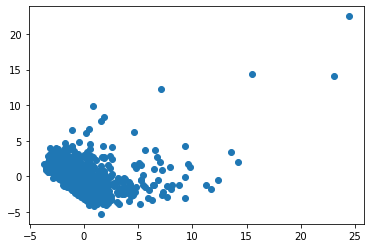

In [13]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_intensity_data)
import matplotlib.pyplot as plt 
plt.scatter(pca_data[:,0], pca_data[:,1])
plt.show()

### UMAP EMBEDDING
Note change code here if you wish to use PCA reduced data.

In [31]:
import umap
reducer = umap.UMAP()

/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


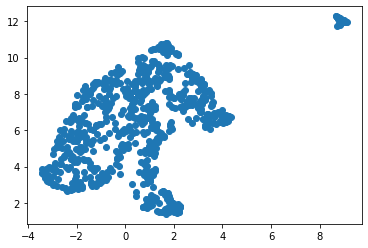

In [32]:
embedding = reducer.fit_transform(scaled_intensity_data)
plt.scatter(embedding[:,0],embedding[:,1])
plt.show()

### K-Means Clustering
change n_clusters as needed

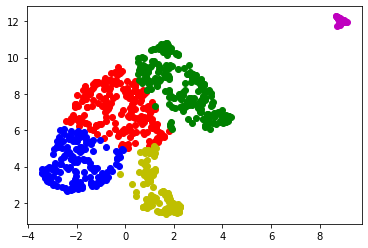

In [34]:
from sklearn.cluster import KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding)
colors = ['r','g','b','y','m']
for cluster in range(n_clusters):
    plt.scatter(embedding[kmeans.labels_==cluster,0],embedding[kmeans.labels_==cluster,1], c=colors[cluster])
plt.show()


#### Write clusters to images!

In [36]:
for cluster in range(n_clusters):
    print(cluster)
    out = np.zeros(shape=img.shape,dtype=np.bool_)
    for lab in GG.iloc[:,-1].values[np.argwhere(kmeans.labels_==cluster).flatten()]: #the last column is the cell label from skimage.
        out[lab_im==lab]=True
    pths = os.path.splitext(path) #get file name and path.
    io.imsave(pths[0]+'_cluster_{}.png'.format(cluster), out) #write as a png file


0


/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_0.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  import sys
/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_0.png is a low contrast image
  import sys


1


/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_1.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  import sys
/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_1.png is a low contrast image
  import sys


2


/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_2.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  import sys
/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_2.png is a low contrast image
  import sys


3


/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_3.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  import sys
/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_3.png is a low contrast image
  import sys


4


/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_4.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  import sys
/Users/eddyc/opt/anaconda3/envs/cyc_IF/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: /users/eddyc/documents/project_2/test_eval/test/48411_Scene XXX - TUBB3 SBcells_cluster_4.png is a low contrast image
  import sys


In [42]:
kmeans.labels_

array([2, 0, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 0,
       1, 0, 2, 2, 1, 1, 0, 2, 0, 0, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 0,
       0, 1, 2, 0, 2, 2, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 1, 2, 2, 1,
       0, 0], dtype=int32)

In [41]:
np.argwhere(kmeans.labels_==0).flatten()

array([ 1,  3, 16, 17, 20, 21, 23, 28, 30, 31, 43, 44, 47, 50, 55, 56, 66,
       67])

In [46]:
df.iloc[:,-3].values

array([   10,   556,   685,  1306,  1341,  2101,  2363,  2384,  2410,
        2620,  2809,  2812,  2821,  3019,  3068,  3918,  4109,  4233,
        4500,  4669,  4726,  4782,  5543,  5672,  5716,  5995,  6032,
        6084,  6145,  6232,  6284,  6286,  6377,  6436,  6638,  6948,
        7073,  7772,  7784,  8025,  8099,  8749,  8976,  9126,  9135,
        9226,  9260,  9294,  9419,  9503,  9590,  9675,  9758,  9759,
        9787,  9900, 10115, 10371, 10460, 10491, 10555, 10629, 10919,
       11310, 11452, 11490, 11530, 11550])

In [47]:
df.iloc[:,-3].values[np.argwhere(kmeans.labels_==cluster).flatten()]

array([  556,  1306,  4109,  4233,  4726,  4782,  5672,  6145,  6284,
        6286,  9126,  9135,  9294,  9590,  9900, 10115, 11530, 11550])

In [ ]:
def tile_image(image, tile_size, p_overlap=0.25):
	"""
	Need a function to run detection on images which are too big.
	Goal: (1) Tile, hold positions
			(2) Run detection on images.
			These should be loaded into detect.
			We either need to rework detect, or run_inference.
	Need to return "tiles" with keys (see stitch_image). but put in entry for locs.
	Make overlap at least 50% of the tile_size
	image should be size
	"""
	assert p_overlap<=1, "overlap percentage (decimal) must be less than 1"
	h_im, w_im = image.shape[:2]
	tile_size = int(tile_size)
	p_tile = int(np.ceil(tile_size*p_overlap))
	n_slices_vert = int(np.ceil(h_im / p_tile))
	n_slices_horz = int(np.ceil(w_im / p_tile))

	#Decide padding, if necessary.
	if h_im<n_slices_horz*p_tile:
		n_pad_rows = n_slices_vert*p_tile - h_im
	else:
		n_pad_rows = 0
	if w_im<n_slices_horz*p_tile:
		n_pad_cols = n_slices_horz*p_tile - w_im
	else:
		n_pad_cols = 0

	#apply padding to bottom row and last column only.
	Im_pad = copy.deepcopy(image)

	#THE PADDING HERE IS A PROBLEM IN DETECTION. It introduces a lot of noise in the detection.
	#We may instead want to end the last image differently. Or, mirror it.
	#break image into tiles.
	#reflect doesn't work, since in CellPose, you need to calculate gradients.
	#instead, we need to take last images differently.

	#determine start points for tiles to run detection on.
	#if doing padding, the next commented line works.
	#locs = [((ri,ri+tile_size),(ci,ci+tile_size)) for ri in range(0,h_im,p_tile) for ci in range(0, w_im, p_tile)]
	#the following code is for non-padded.
	locs=[]
	for ri in range(0,h_im,p_tile):
		for ci in range(0,w_im,p_tile):
			if ri+tile_size>h_im and ci+tile_size>w_im: #we are at the sets pf rows and columns
				locs.append(((h_im-tile_size,h_im),(w_im-tile_size,w_im)))
			elif ri+tile_size>h_im and ci+tile_size<=w_im: #we are at the last set of rows
				locs.append(((h_im-tile_size,h_im),(ci,ci+tile_size)))
			elif ri+tile_size<=h_im and ci+tile_size>w_im: #we are at the last set of columns
				locs.append(((ri,ri+tile_size),(w_im-tile_size,w_im)))
			else: #
				locs.append(((ri,ri+tile_size),(ci,ci+tile_size)))
	#There is overlap in these tiles. In CellPose, there is also edge effects when calculating
	#the gradients. Therefore, we want to only take the inner portions of each image.
	#Determine the acceptable windows of each tile image to use.
	trim_amount = int((1-p_overlap)*tile_size/2)
	#hmins = [ri + trim_amount if ri>0 else 0 for ri in range(0,h_im,p_tile)]#for ((ri,_),(_,_)) in locs]
	hmins = [0 if ri==0 else ri + trim_amount if ri + trim_amount <= h_im else ind*tile_size for ind,ri in enumerate(range(0,h_im,p_tile))]#for ((ri,_),(_,_)) in locs]
	#hmaxs = [ri + tile_size - trim_amount if ri + tile_size < h_im else ri + tile_size for ri in range(0,h_im,p_tile)]
	hmaxs = [ri + tile_size - trim_amount if ri + tile_size < h_im else h_im for ri in range(0,h_im,p_tile)]
	#wmins = [wi + trim_amount if wi>0 else 0 for wi in range(0, w_im, p_tile)]#for ((_,_),(wi,_)) in locs]
	wmins = [0 if wi==0 else wi + trim_amount if wi + trim_amount <= w_im else ind*tile_size for ind,wi in enumerate(range(0,w_im,p_tile))]#for ((ri,_),(_,_)) in locs]
	#wmaxs = [wi + tile_size - trim_amount if wi + tile_size < w_im else wi + tile_size for wi in range(0, w_im, p_tile)]
	wmaxs = [wi + tile_size - trim_amount if wi + tile_size < w_im else w_im for wi in range(0, w_im, p_tile)]

	#locs looks like list of each tile's (initial row, final row), (initial column, final column)
	#im_tiles = [Im_pad[ri:rend,ci:cend] for (ri,rend,ci,cend) in tiles['windows']]
	im_tiles = [Im_pad[x[0][0]:x[0][1],x[1][0]:x[1][1]] for x in locs]
	#import pdb;pdb.set_trace()

	rows = list(zip(hmins,hmaxs))
	cols = list(zip(wmins,wmaxs))
	import itertools
	windows = list(itertools.product(rows,cols))
	windows = [tuple(x[0] + x[1]) for x in windows]
	#create tiles dictionary
	tiles = {}
	#tiles['locs']=locs
	tiles['padding']=[n_pad_rows,n_pad_cols]
	tiles['init_shape']=(h_im,w_im)
	tiles['dtype']=image.dtype
	tiles['trim']=trim_amount
	tiles['windows']=windows
	tiles['mask']=[]
	#verify locs and windows line up. Checked, looks good.
	return tiles, im_tiles

def stitch_image(tile_size, tiles):
	"""
	tiles should be a dictionary, with args 'windows','dtype', 'image', 'mask', 'padding', 'init_shape'
	each key should be a list with tiles.
	How do we stitch together the predicted grads?
	Well, whereever the mask is on the border, we want to erase it.
	Therefore, use np.where and make the grads also zero wherever the mask is at on the border
	Then, just use max arg for edges.
	"""

	#for image, stitch together using max projection
	shape_to=tiles['init_shape']#[int(np.sum(el)) for el in zip(list(tiles['init_shape']),tiles['padding'])]
	image = np.zeros(shape=tuple(shape_to), dtype = tiles['dtype'])


	for tile_i in range(len(tiles['image'])):
		#x = tiles['locs'][tile_i]
		(ri,rend,ci,cend) = tiles['windows'][tile_i] #these are placements into image.

		if ri==0:
			rstart = 0
		elif rend==tiles['init_shape'][0]:
			rstart = tile_size-(rend-ri)
		else:
			rstart = tiles['trim']
		if ci==0:
			cstart = 0
		elif cend==tiles['init_shape'][1]:
			cstart=tile_size-(cend-ci)
		else:
			cstart = tiles['trim']
		if rend < tiles['init_shape'][0]:
			rstop = tile_size - tiles['trim']
		else:
			rstop = tile_size
		if cend < tiles['init_shape'][1]:
			cstop = tile_size - tiles['trim']
		else:
			cstop = tile_size
		#so to be clear, rstart,rstop,cstart,cstop are the indices for the tile.
		#import pdb;pdb.set_trace()
		if len(tiles['image'][tile_i].shape)==3:
			this_im = tiles['image'][tile_i][rstart:rstop,cstart:cstop,0] #note the 0 is just since there was an added channel.
		else:
			this_im = tiles['image'][tile_i][rstart:rstop,cstart:cstop]
		image[ri:rend,ci:cend] = this_im


	#for mask, remove objects that are on the border. For deleted pixels, delete the same Pixels
	#from xgrad and ygrad.
	mask = np.zeros(shape=tuple(shape_to)+(tiles['channels'],), dtype = tiles['mask'][0].dtype)

	#entered_array = np.zeros(shape=tuple(shape_to)) #keeps track of where pixels have been placed.

	#from skimage.measure import label
	#The way "clear_border" works is that it assumes 8-bit connectivity.
	#You can change that by first labeling the image
	#from skimage.segmentation import clear_border
	for tile_i in range(len(tiles['image'])):

		(ri,rend,ci,cend) = tiles['windows'][tile_i] #these are placements into image.

		if ri==0:
			rstart = 0
		elif rend==tiles['init_shape'][0]:
			rstart = tile_size-(rend-ri)
		else:
			rstart = tiles['trim']
		if ci==0:
			cstart = 0
		elif cend==tiles['init_shape'][1]:
			cstart=tile_size-(cend-ci)
		else:
			cstart = tiles['trim']
		if rend < tiles['init_shape'][0]:
			rstop = tile_size - tiles['trim']
		else:
			rstop = tile_size
		if cend < tiles['init_shape'][1]:
			cstop = tile_size - tiles['trim']
		else:
			cstop = tile_size


		this_mask = tiles['mask'][tile_i][rstart:rstop,cstart:cstop,:]

		mask[ri:rend,ci:cend,:] = this_mask


	image = image[0:tiles['init_shape'][0],0:tiles['init_shape'][1]]
	mask = mask[0:tiles['init_shape'][0],0:tiles['init_shape'][1],:]

	return image, mask